In [1]:
# !pip install -q transformers datasets tokenizers

In [2]:
import torch
import gc
# pray before using
def clean_my_cuda():
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                del(obj)
        except:
            pass

    gc.collect()
    torch.cuda.empty_cache()

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [5]:
# try running twice if it fails

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [6]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [7]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/home/arsen/.cache/huggingface/datasets/emotion/default/0.0.0/5276a3f9a2c014ee528f5cca7ad34f185b886acd0f60fe18c61c6768662ca828)


Посмотри, из чего состоит `emotion_dataset`:

In [8]:
emotion_dataset

DatasetDict({'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000), 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000), 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)})

In [9]:
emotion_dataset["train"]

Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000)

In [10]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [11]:
emotion_dataset["train"]["label"][0]

'sadness'

In [12]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [13]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [14]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [15]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [16]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [17]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [18]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [19]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [20]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt")
        
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'].squeeze(0), 
            "mask": tokenizer_output['attention_mask'].squeeze(0),
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [21]:
train_dataset = TweetDataset('train')
valid_dataset = TweetDataset('validation') # validation
test_dataset = TweetDataset('test')

In [22]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [23]:
print(torch.cuda.memory_allocated())

0


In [24]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

In [25]:
print(torch.cuda.memory_allocated()/(1024**3)) # GB

0.31177806854248047


Подготовь оптимайзер и критерий:

In [26]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

In [27]:
print(torch.cuda.memory_allocated()/(1024**3)) # GB

0.31177806854248047


Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [28]:
example = train_dataset[0]
# unsqueeze to make it batch-like dimensionwise
tokens = example['input_ids'].to(device).unsqueeze(0) # Получи токены из датасета
mask = example['mask'].to(device).unsqueeze(0) # Получи маску из датасета
output = model_0(input_ids = tokens, attention_mask=mask) # Посмотри на аутпут

In [29]:
print(torch.cuda.memory_allocated()/(1024**3)) # GB

0.4102444648742676


In [30]:
for i in output:
    if type(i) == type(()):
        print(type(i))
        for j in i:
            print('\t', j.shape)
    else:
        print(i.shape)
    print('\n')
# first tensor should be [batch_size, num_labels==8]

torch.Size([1, 8])


<class 'tuple'>
	 torch.Size([2, 1, 12, 128, 64])
	 torch.Size([2, 1, 12, 128, 64])
	 torch.Size([2, 1, 12, 128, 64])
	 torch.Size([2, 1, 12, 128, 64])
	 torch.Size([2, 1, 12, 128, 64])
	 torch.Size([2, 1, 12, 128, 64])


<class 'tuple'>
	 torch.Size([1, 12, 128, 128])
	 torch.Size([1, 12, 128, 128])
	 torch.Size([1, 12, 128, 128])
	 torch.Size([1, 12, 128, 128])
	 torch.Size([1, 12, 128, 128])
	 torch.Size([1, 12, 128, 128])




Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [43]:
from tqdm.notebook import tqdm

num_epochs = 10
# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        
        optimizer.zero_grad()
        
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)
        
        output = model_0(input_ids = input_ids, attention_mask=mask)[0]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            
            target = batch['target'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['mask'].to(device)
            
            output = model_0(input_ids = input_ids, attention_mask=mask)[0]
            _, predicted = torch.max(output, 1)
            
            valid_loss += criterion(output, target).item()
            valid_acc += (predicted == target).sum().item()/target.size(0)
        
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
    last_val_acc = valid_acc / len(valid_loader)
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)

        output = model_0(input_ids = input_ids, attention_mask=mask)[0]
        _, predicted = torch.max(output, 1)

        test_acc += (predicted == target).sum().item()/target.size(0)
        
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 0.14192015592753887,Valid Loss: 0.5616078469902277,Valid Acc: 0.83447265625



Train Loss: 0.13337560446560384,Valid Loss: 0.5616078469902277,Valid Acc: 0.83447265625



Train Loss: 0.13009576538205148,Valid Loss: 0.5616078469902277,Valid Acc: 0.83447265625



Train Loss: 0.1297804884761572,Valid Loss: 0.5616078469902277,Valid Acc: 0.83447265625



Train Loss: 0.1333840610086918,Valid Loss: 0.5616078469902277,Valid Acc: 0.83447265625



Train Loss: 0.13524223731458188,Valid Loss: 0.5616078469902277,Valid Acc: 0.83447265625



Train Loss: 0.13444672816991807,Valid Loss: 0.5616078469902277,Valid Acc: 0.83447265625



Train Loss: 0.13467350725829602,Valid Loss: 0.5616078469902277,Valid Acc: 0.83447265625



Train Loss: 0.1271661054044962,Valid Loss: 0.5616078469902277,Valid Acc: 0.83447265625



Train Loss: 0.12966802540421485,Valid Loss: 0.5616078469902277,Valid Acc: 0.83447265625
Test Acc: 0.83154296875


In [44]:
torch.save(model_0.state_dict(), f'./model_0_acc:{last_val_acc:.3f}.pt')

После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [45]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [75]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [76]:
def show_all_attentions(seq, all_attentions):
    num = 1
    n_layers = all_attentions.shape[0]
    n_heads = all_attentions.shape[1]
    
    fig = plt.figure(figsize=(20,10))
    
    for layer in range(n_layers):
        for head in range(n_heads):
            ax = fig.add_subplot(n_layers, n_heads, num)
            cax = ax.matshow(all_attentions[layer][head])
            num += 1
            
            plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False, labeltop=False)
            
    plt.show()

In [47]:
train_dataset[0]

{'input_ids': tensor([   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50

In [86]:
text = emotion_dataset["train"]["text"][3] # Выбери текст из датасета
print(text)
tokens = tokenizer.tokenize(text)

i am ever feeling nostalgic about the fireplace i will know that it is still on the property


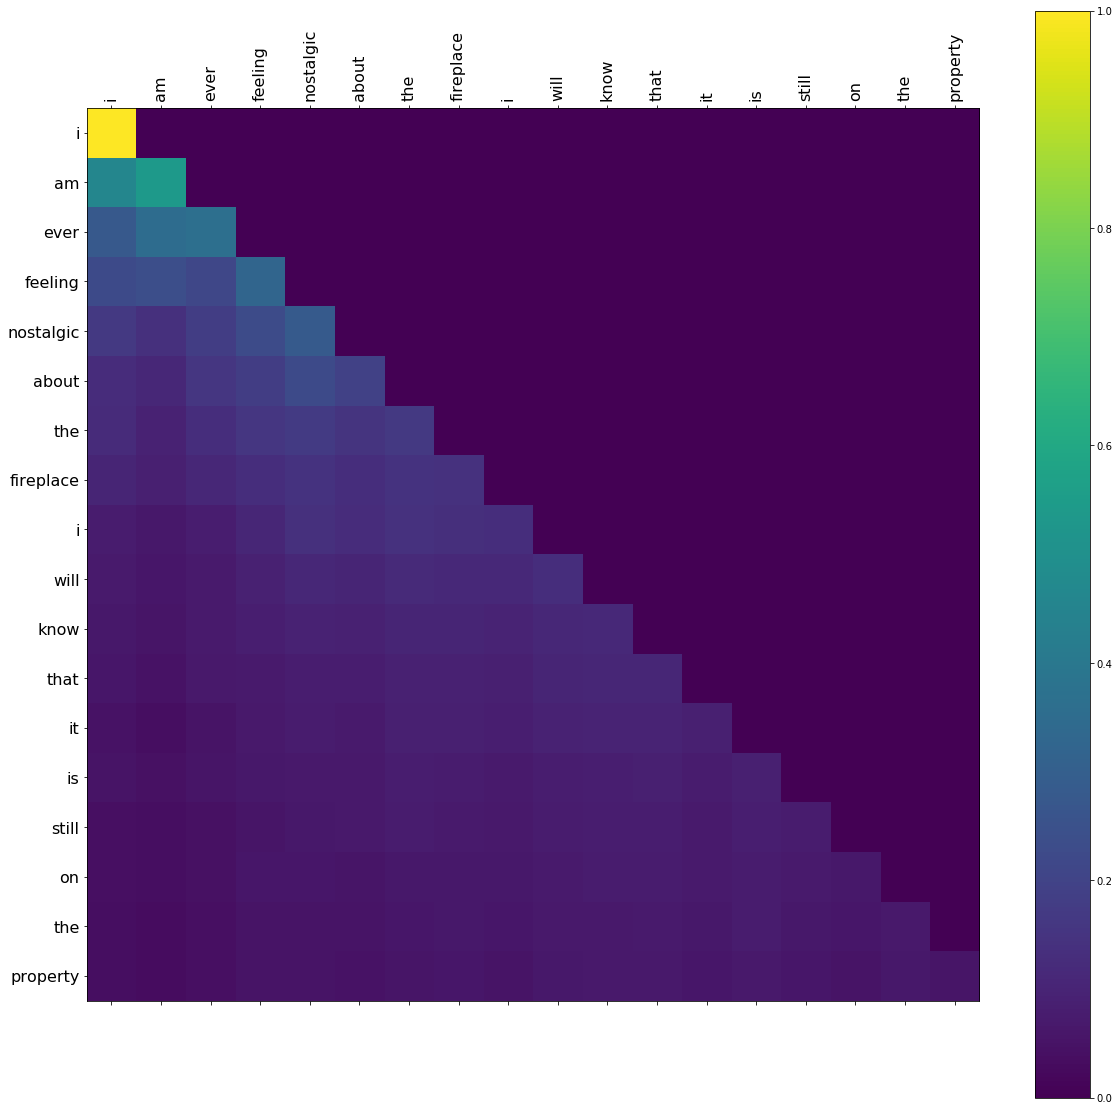

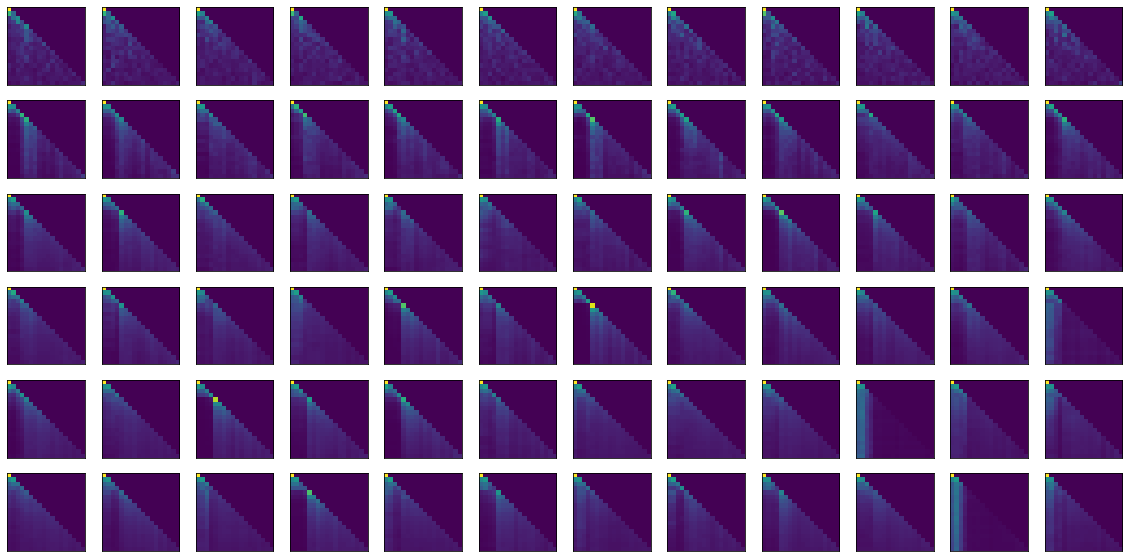

In [88]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(text.split(), attns[-1][0])
show_all_attentions(text.split(), attns)

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [80]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [82]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        
        target = batch['target'].to(device)
        input_ids = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)
        
        output = model_1(input_ids = input_ids, attention_mask=mask)[0]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            target = batch['target'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['mask'].to(device)
            
            output = model_1(input_ids = input_ids, attention_mask=mask)[0]
            _, predicted = torch.max(output, 1)
            
            valid_loss += criterion(output, target).item()
            valid_acc += (predicted == target).sum().item()/target.size(0)
            
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
    last_val_acc = valid_acc / len(valid_loader)
    
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        ...
print(f"Test Acc: {test_acc / len(test_loader)}")


Train Loss: 1.8709569611549377,Valid Loss: 1.1117790937423706,Valid Acc: 0.603515625



Train Loss: 0.8080189419984818,Valid Loss: 0.4641544399783015,Valid Acc: 0.84228515625



Train Loss: 0.4289636719226837,Valid Loss: 0.29828661517240107,Valid Acc: 0.90234375



Train Loss: 0.292576464176178,Valid Loss: 0.21061744261533022,Valid Acc: 0.92333984375



Train Loss: 0.22661508120596408,Valid Loss: 0.18120269244536757,Valid Acc: 0.92724609375



Train Loss: 0.1895730807930231,Valid Loss: 0.16802551643922925,Valid Acc: 0.93359375



Train Loss: 0.1626689850538969,Valid Loss: 0.16039500071201473,Valid Acc: 0.93408203125



Train Loss: 0.1498054473400116,Valid Loss: 0.15718477580230683,Valid Acc: 0.9326171875


KeyboardInterrupt: 

In [83]:
torch.save(model_1.state_dict(), f'./model_1_acc:{last_val_acc:.3f}.pt')

Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [89]:
text = emotion_dataset["train"]["text"][3] # Выбери текст из датасета
print(text)
tokens = tokenizer.tokenize(text)

i am ever feeling nostalgic about the fireplace i will know that it is still on the property


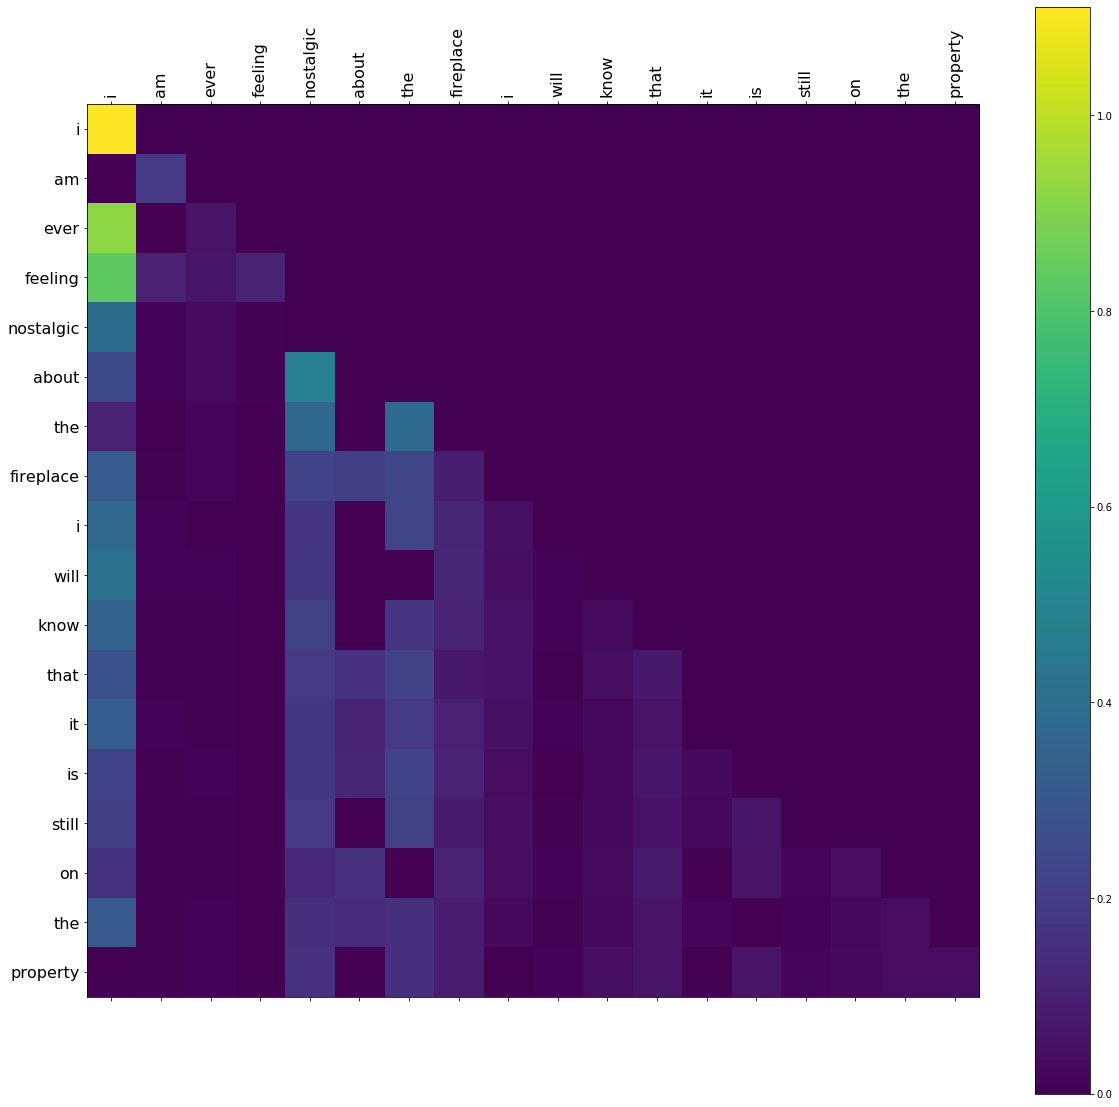

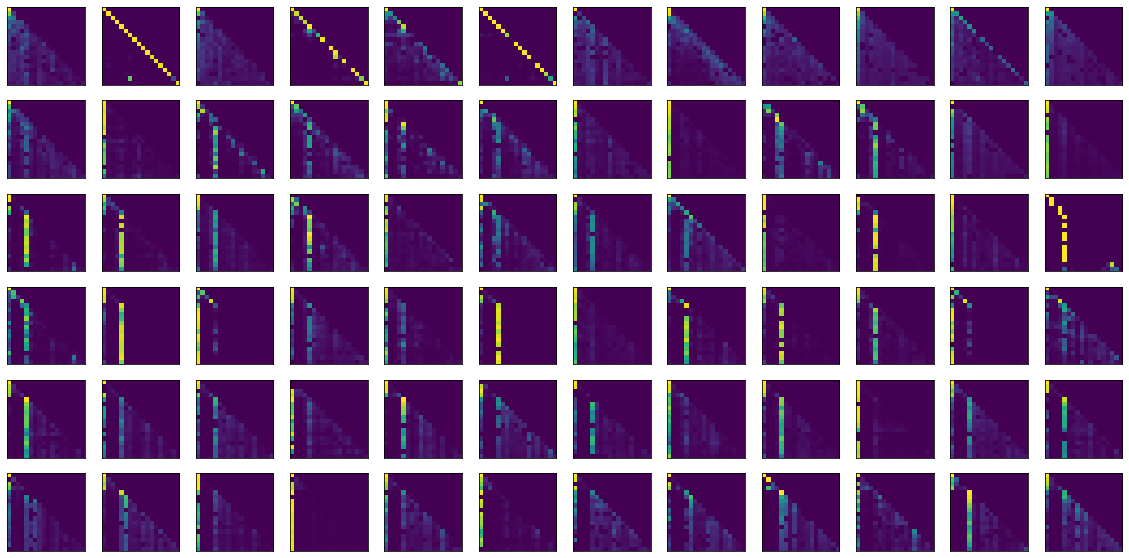

In [90]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(text.split(), attns[-1][0])
show_all_attentions(text.split(), attns)

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

Предобученная модель ожидаемо показала заметно более высокое accuracy после 10 эпох обучения: 0.838 у первой модели против 0.936 у второй

Первая модель: В основном внимание достаточно равномерно распределяется по предложению, но на некоторых головах (редко в первом\последнем слое, чаще в середине) внимание (в основном self-attention или соседние слова) обращается на несколько слов с четкой эмоциональной окраской заметно больше, чем на остальные, причем слова одни и те же между разными слоями\головами.

Вторая модель: Внимание сильнее меняется от головы к голове, но тренд тот же: эмоционально окрашенные слова, но при этом значимое изменение - внимание сохраняется на протяжении предложения, а не как в случае с первой моделью, где заметен был пик только в селф-аттеншене и следующем слове.

PS Лосс на валидации и точность в первой модели "не меняются", так как я случайно заново запустил клетку с train loop'ом для первой модели с оптимайзером для второй, соответственно веса первой модели не менялись